In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
np.random.seed(42)


In [2]:
# Generate fake data with 5 features and 100 samples
n_samples = 1000
p_features = 200
total_features = 400

stds = np.random.uniform(0.1, 20, p_features)
means = np.random.uniform(-10, 10, p_features)
features = np.zeros((n_samples, total_features))
features[:, :p_features] = np.random.normal(0, stds, (n_samples, p_features))

In [3]:
for i in range(p_features, total_features):
    generalized_feature = features[:,:p_features] @ np.random.normal(0, 1, p_features)
    features[:, i] = generalized_feature

In [4]:
data = features.copy()

# normalize the data
data = (data - data.mean(axis=0)) / data.std(axis=0)

In [5]:
# Apply PCA
pca = PCA(n_components=total_features)
pca_result = pca.fit_transform(data)

In [6]:
# Explained variance ratio for each principal component
explained_variance = pca.explained_variance_ratio_

<Axes: >

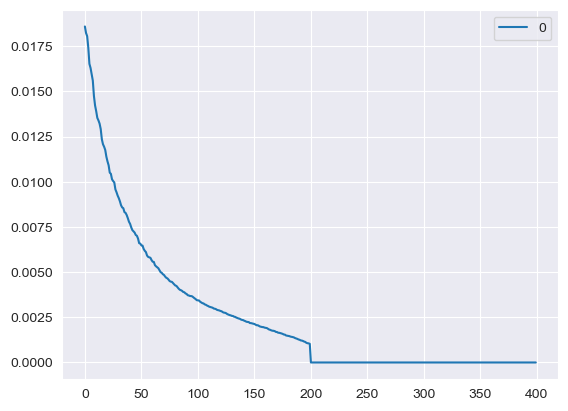

In [7]:
pd.DataFrame(explained_variance).plot()

In [73]:
# Test Feature
random_int = np.random.randint(0, p_features)
random_int = 30
betas = np.random.normal(0, 1, random_int)
test_feature = pca_result[:,:random_int] @ betas

In [74]:
def rolling_corr(df, target_col, window=30):
    # Calculate rolling correlation with respect to the target column
    rolling_corr_df = df.rolling(window).corr(df[target_col])
    
    # Drop the target column from the resulting DataFrame
    rolling_corr_df = rolling_corr_df.drop(columns=[target_col])
    
    return rolling_corr_df.dropna()

In [75]:
test_data = pd.DataFrame(pca_result.copy())
test_data.columns = [f'PC_{i}' for i in range(total_features)]
test_data['test_feature'] = test_feature

In [76]:
roll_coef_df = rolling_corr(test_data, 'test_feature', window=30)

<Axes: >

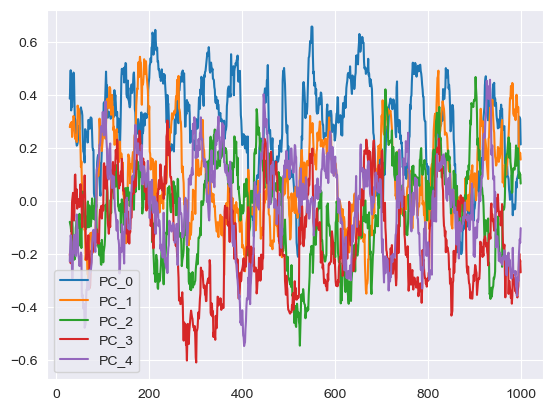

In [77]:
roll_coef_df.iloc[:,0:5].plot()

In [78]:
stds = roll_coef_df.rolling(30).std().unstack()

The 5% quantile of the standard deviation of the correlation coefficient distribution is: 0.04935819229533957
The 25% quantile of the standard deviation of the correlation coefficient distribution is: 0.07033184121317268


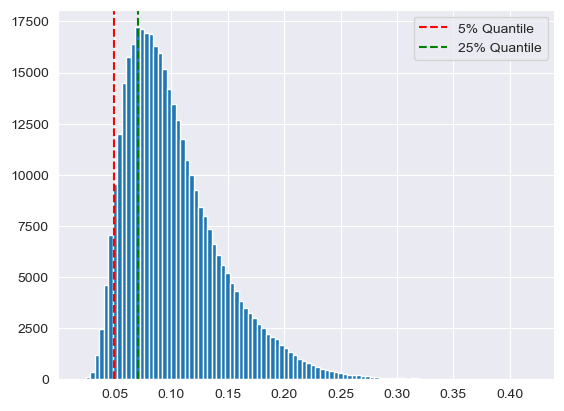

In [79]:
std_all = stds.droplevel(0)
std_all.hist(bins=100)
std_all.dropna(inplace=True)

print("The 5% quantile of the standard deviation of the correlation coefficient distribution is:", std_all.quantile(0.05))

print("The 25% quantile of the standard deviation of the correlation coefficient distribution is:", std_all.quantile(0.25))

plt.axvline(std_all.quantile(0.05), color='r', linestyle='--', label='5% Quantile')
plt.axvline(std_all.quantile(0.25), color='g', linestyle='--', label='25% Quantile')
plt.legend()
plt.show()

In [80]:
selection_range = [0, 0.01]
q1_range = [0.01, 0.35]
q2_range = [0.35, 0.65]
q3_range = [0.65, 0.95]
q4_range = [0.95, 1]
q5_range = [0.99, 1]

# calculate distribution entropy
def entropy(x):
    return -np.sum(x * np.log(x))

def calculate_entropy(df, q_range):
    return entropy(df[(df > df.quantile(q_range[0])) & (df < df.quantile(q_range[1]))].groupby(level=0).count().value_counts(normalize=True))

print("Entropy for the selection range:", calculate_entropy(stds, selection_range))
print("Entropy for the first quantile range:", calculate_entropy(stds, q1_range))
print("Entropy for the second quantile range:", calculate_entropy(stds, q2_range))
print("Entropy for the third quantile range:", calculate_entropy(stds, q3_range))
print("Entropy for the fourth quantile range:", calculate_entropy(stds, q4_range))
print("Entropy for the fifth quantile range:", calculate_entropy(stds, q5_range))

Entropy for the selection range: 3.283244723323736
Entropy for the first quantile range: 5.140886650456559
Entropy for the second quantile range: 4.885887880562757
Entropy for the third quantile range: 5.082773872629608
Entropy for the fourth quantile range: 4.479428767488848
Entropy for the fifth quantile range: 3.453616833117613


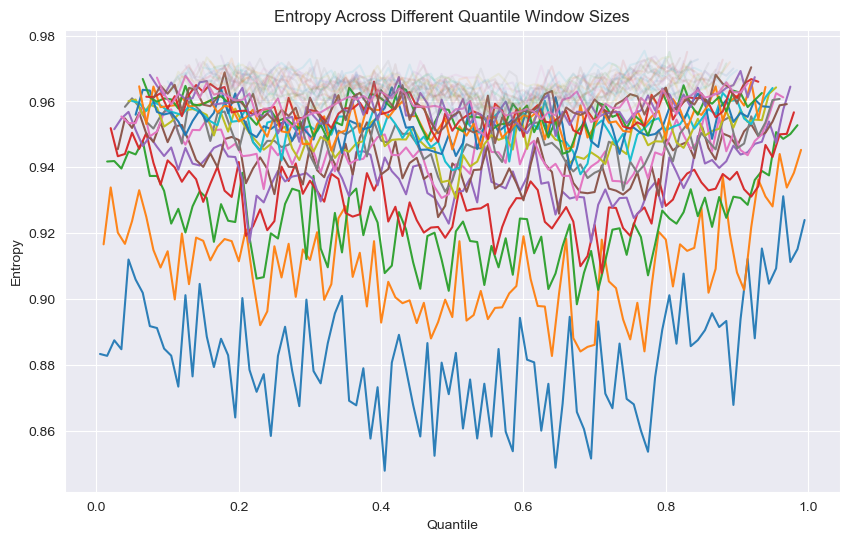

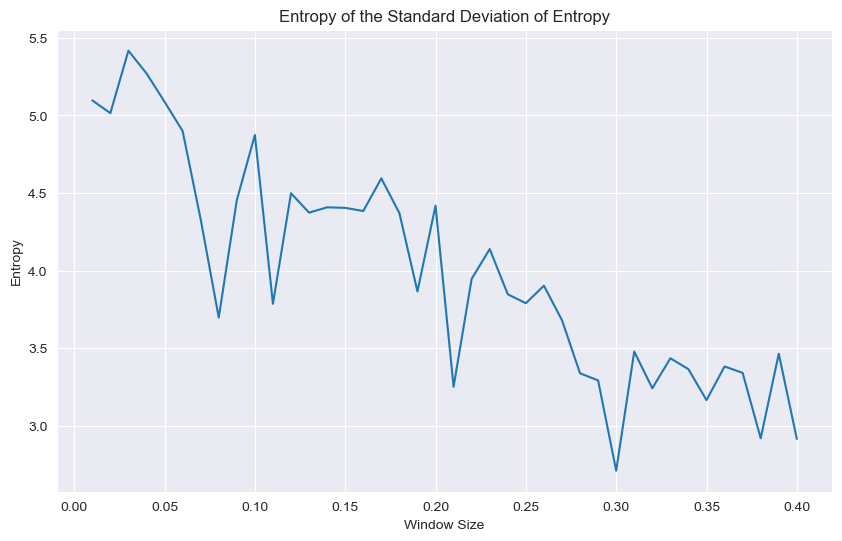

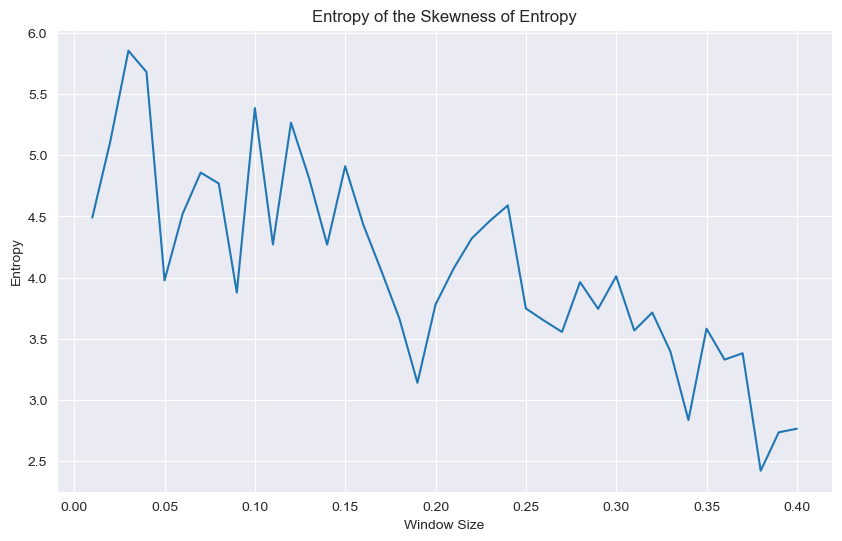

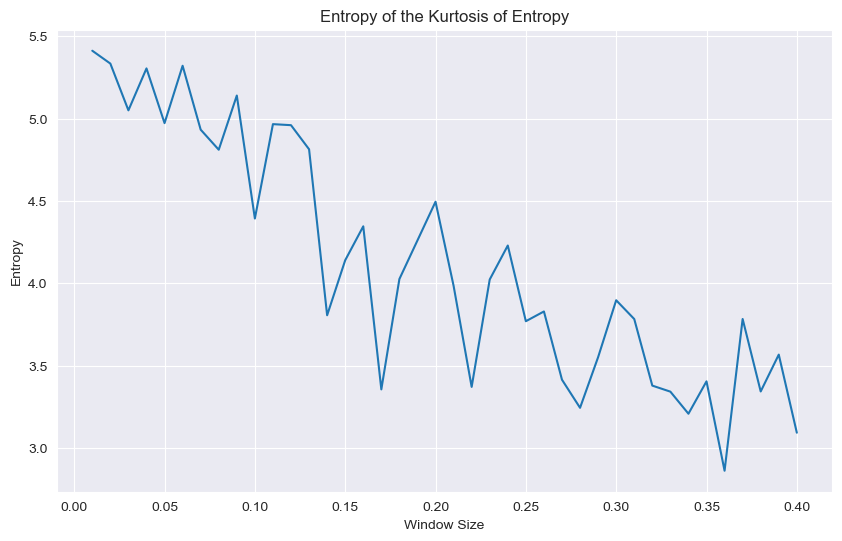

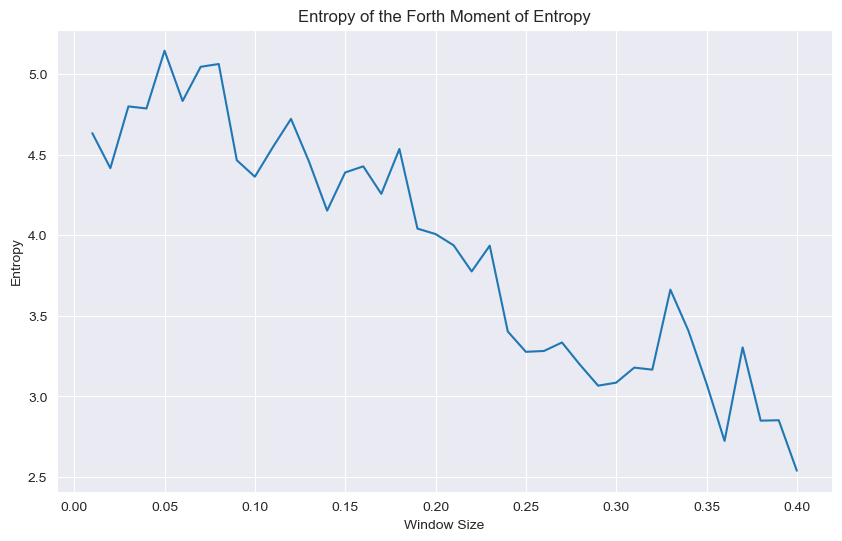

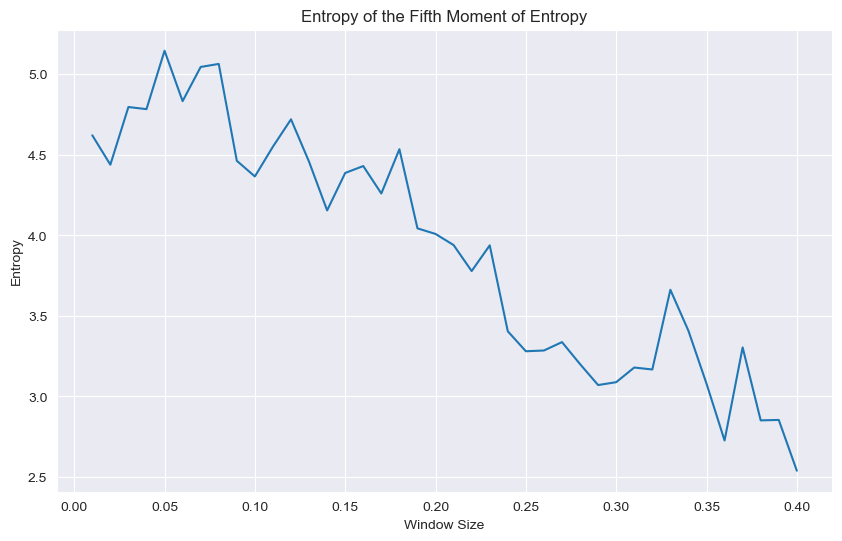

In [81]:
import numpy as np
import pandas as pd

# Calculate distribution entropy
def entropy(x, normalize=False):
    if len(x) == 0:  # Prevent calculation on empty arrays
        return 0
    if normalize:
        return -np.sum(x * np.log(x + 1e-9)) / np.log(len(x))
    return -np.sum(x * np.log(x + 1e-9))  # Adding small value to avoid log(0)

# Function to calculate entropy within a sliding quantile window
def sliding_quantile_entropy(df, window_quantile_size, step_quantile_size):
    quantiles = np.arange(0, 1 + step_quantile_size, step_quantile_size)
    entropies = []
    indices = []
    
    for start in quantiles:
        end = start + window_quantile_size
        if end > 1:
            break  # Ensure we don't go beyond the maximum quantile
        
        lower_bound = df.quantile(start)
        upper_bound = df.quantile(end)
        
        window = df[df >= lower_bound][df < upper_bound]
        counts = window.groupby(level=0).count().value_counts(normalize=True)
        entropies.append(entropy(counts, normalize=True))
        indices.append(start + window_quantile_size / 2)
    
    return entropies, indices

# Parameters for sliding window in quantile space
window_quantile_size = 0.1  # Size of the window in quantile space
step_quantile_size = 0.01  # Step size in quantile space
entropies_std =[]
entropies_skew = []
entropies_kurtosis = []
entropies_forth_moment = []
entropies_fifth_moment = []

# Initialize plot
plt.figure(figsize=(10, 6))

rolling_entropy_window = 20

# Loop over different window sizes and plot on the same graph
for window_quantile_size in np.arange(0.01, 0.41, 0.01):
    entropies, indices = sliding_quantile_entropy(stds, window_quantile_size, step_quantile_size)
    entropies_df = pd.DataFrame(entropies, columns=['entropy'], index=indices)
    # plt.plot(entropies_df.index, entropies_df['entropy'], label=f'Window size: {round(window_quantile_size, 3)}')
    # rolling std of entropy
    alpha = 0.1 
    if abs(window_quantile_size - random_int/400) < 0.1:
        alpha = 1 * (1 - abs(window_quantile_size - random_int/400))
    plt.plot(entropies_df.index, entropies_df['entropy'], label=f'Window size: {round(window_quantile_size, 3)}' , alpha=alpha)
    
    # Calculate entropy
    mean_values = entropies_df['entropy'].rolling(rolling_entropy_window).mean().dropna().values
    std_values = entropies_df['entropy'].rolling(rolling_entropy_window).std().dropna().values
    skew_values = entropies_df['entropy'].rolling(rolling_entropy_window).skew().dropna().values
    kurtosis_values = entropies_df['entropy'].rolling(rolling_entropy_window).kurt().dropna().values
    forth_moment_values = entropies_df['entropy'].rolling(rolling_entropy_window).apply(lambda x: np.mean(x**4)).dropna().values
    fifth_moment_values = entropies_df['entropy'].rolling(rolling_entropy_window).apply(lambda x: np.mean(x**5)).dropna().values
    
    # calculate the entropy of the std values
    std_values = (std_values - std_values.min())/ (std_values.max() - std_values.min()) 
    skew_values = (skew_values - skew_values.min())/ (skew_values.max() - skew_values.min())
    kurtosis_values = (kurtosis_values - kurtosis_values.min())/ (kurtosis_values.max() - kurtosis_values.min())
    forth_moment_values = (forth_moment_values - forth_moment_values.min())/ (forth_moment_values.max() - forth_moment_values.min())
    fifth_moment_values = (fifth_moment_values - fifth_moment_values.min())/ (fifth_moment_values.max() - fifth_moment_values.min())
    
    entropy_std = entropy(std_values, normalize=True)
    entropy_skew = entropy(skew_values, normalize=True)
    entropy_kurtosis = entropy(kurtosis_values, normalize=True)
    entropy_forth_moment = entropy(forth_moment_values, normalize=True)
    entropy_fifth_moment = entropy(fifth_moment_values, normalize=True)
    
    entropies_std.append(entropy_std)
    entropies_skew.append(entropy_skew)
    entropies_kurtosis.append(entropy_kurtosis)
    entropies_forth_moment.append(entropy_forth_moment)
    entropies_fifth_moment.append(entropy_fifth_moment)

# Customize and show plot
plt.title("Entropy Across Different Quantile Window Sizes")
plt.xlabel("Quantile")
plt.ylabel("Entropy")
plt.grid(True)
# plt.legend()
plt.show()

# Plot the entropy of the std values
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0.01, 0.41, 0.01), entropies_std)
plt.title("Entropy of the Standard Deviation of Entropy")
plt.xlabel("Window Size")
plt.ylabel("Entropy")
plt.grid(True)
plt.show()


# Plot the entropy of the skew values
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0.01, 0.41, 0.01), entropies_skew)
plt.title("Entropy of the Skewness of Entropy")
plt.xlabel("Window Size")
plt.ylabel("Entropy")
plt.grid(True)
plt.show()

# Plot the entropy of the kurtosis values
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0.01, 0.41, 0.01), entropies_kurtosis)
plt.title("Entropy of the Kurtosis of Entropy")
plt.xlabel("Window Size")
plt.ylabel("Entropy")
plt.grid(True)
plt.show()

# Plot the entropy of the forth moment values
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0.01, 0.41, 0.01), entropies_forth_moment)
plt.title("Entropy of the Forth Moment of Entropy")
plt.xlabel("Window Size")
plt.ylabel("Entropy")
plt.grid(True)
plt.show()

# Plot the entropy of the fifth moment values
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0.01, 0.41, 0.01), entropies_fifth_moment)
plt.title("Entropy of the Fifth Moment of Entropy")
plt.xlabel("Window Size")
plt.ylabel("Entropy")
plt.grid(True)
plt.show()

In [85]:
random_int

30

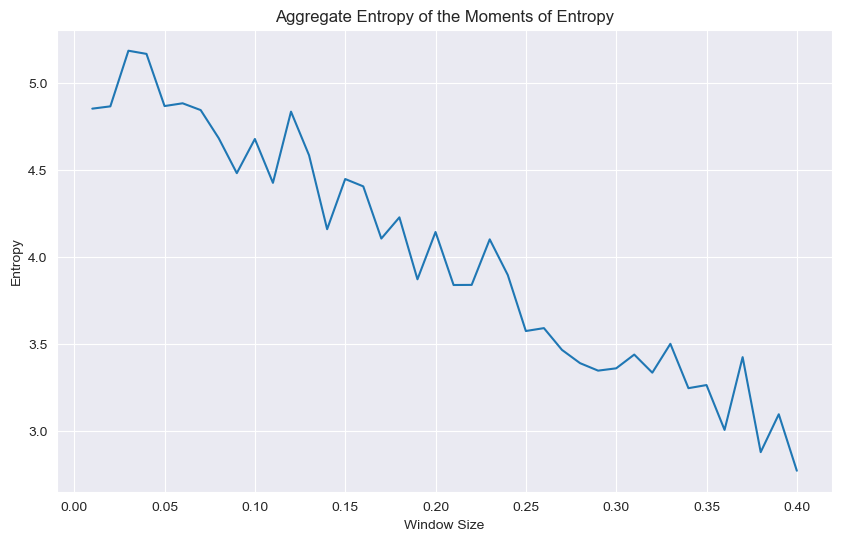

In [83]:
aggregate_entropy = []

for i in range(0, len(entropies_std)):
    # aggregate_value = 1/2*entropies_std[i]**2 + 1/6*entropies_skew[i]**3 + 1/24*entropies_kurtosis[i]**4 + 1/120*entropies_forth_moment[i]**5 + 1/720*entropies_fifth_moment[i]**6
    aggregate_value = np.mean([entropies_std[i], entropies_skew[i], entropies_kurtosis[i], entropies_forth_moment[i], entropies_fifth_moment[i]])
    aggregate_entropy.append(aggregate_value)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(0.01, 0.41, 0.01), aggregate_entropy)
plt.title("Aggregate Entropy of the Moments of Entropy")
plt.xlabel("Window Size")
plt.ylabel("Entropy")
plt.grid(True)

In [84]:
random_int/400

0.075

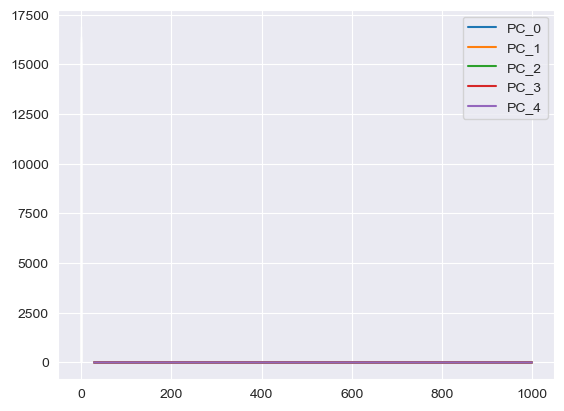

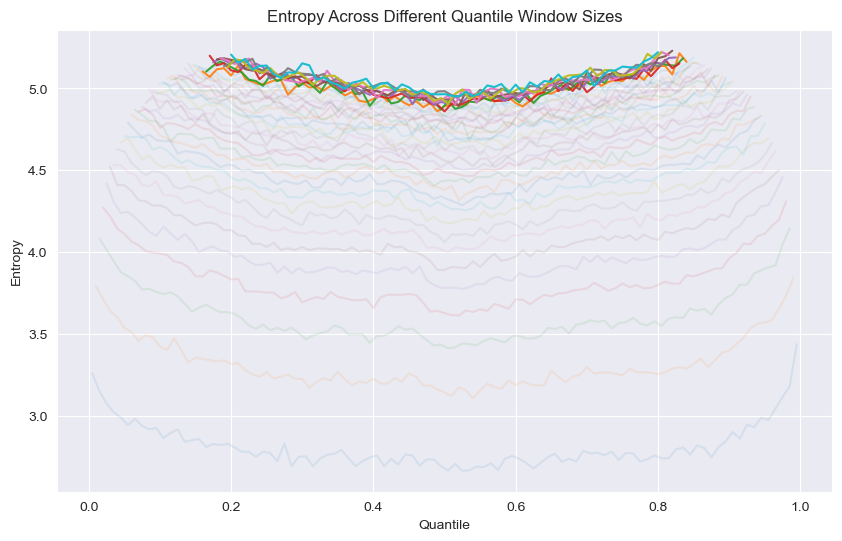

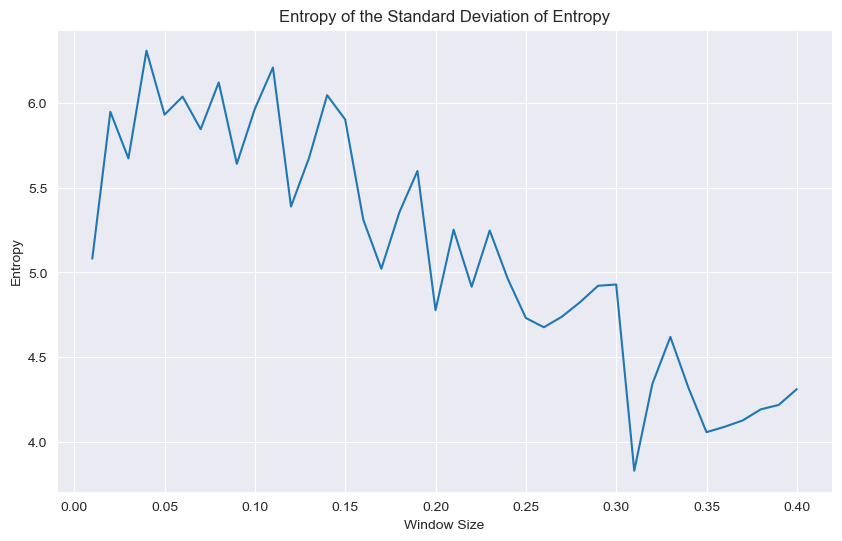

In [68]:
# Test Feature
random_int = np.random.randint(0, p_features)
betas = np.random.normal(0, 1, random_int)
test_feature = pca_result[:, :random_int] @ betas

test_data = pd.DataFrame(pca_result.copy())
test_data.columns = [f'PC_{i}' for i in range(total_features)]
test_data['test_feature'] = test_feature
roll_coef_df = rolling_corr(test_data, 'test_feature', window=30)
roll_coef_df.iloc[:, 0:5].plot()
stds = roll_coef_df.rolling(30).std().unstack()
std_all = stds.droplevel(0)
std_all.hist(bins=100)
std_all.dropna(inplace=True)


step_quantile_size = 0.01  # Step size in quantile space
entropies_std = []

# Initialize plot
plt.figure(figsize=(10, 6))

# Loop over different window sizes and plot on the same graph
for window_quantile_size in np.arange(0.01, 0.41, 0.01):
    entropies, indices = sliding_quantile_entropy(stds, window_quantile_size, step_quantile_size)
    entropies_df = pd.DataFrame(entropies, columns=['entropy'], index=indices)
    # plt.plot(entropies_df.index, entropies_df['entropy'], label=f'Window size: {round(window_quantile_size, 3)}')
    # rolling std of entropy
    alpha = 0.1
    if abs(window_quantile_size - random_int / 400) < 0.1:
        alpha = 1 * (1 - abs(window_quantile_size - random_int / 400))
    plt.plot(entropies_df.index, entropies_df['entropy'], label=f'Window size: {round(window_quantile_size, 3)}',
             alpha=alpha)

    # Calculate entropy
    std_values = entropies_df['entropy'].rolling(5).std().dropna().values

    # calculate the entropy of the std values
    std_values = (std_values - std_values.min()) / (std_values.max() - std_values.min())
    entropy_std = entropy(std_values, normalize=True)
    entropies_std.append(entropy_std)

# Customize and show plot
plt.title("Entropy Across Different Quantile Window Sizes")
plt.xlabel("Quantile")
plt.ylabel("Entropy")
plt.grid(True)
# plt.legend()
plt.show()

# Plot the entropy of the std values
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0.01, 0.41, 0.01), entropies_std)
plt.title("Entropy of the Standard Deviation of Entropy")
plt.xlabel("Window Size")
plt.ylabel("Entropy")
plt.grid(True)
plt.show()
